# Exploration Géolocalisation

Il s'agit pendant cette exploration de trouver une distance qui permet de remonter des offres diversifiées à un utilisateur de l'application Pass Culture.
Les critères de diversifications sont : 
- Pas assigner à résidence (une disance minimale)
- Pas d'offres lointaines ou l'utilisateur ne peut se rendre
- Un nombre de catégories diversifiées

Pour cela, nous allons faire un ensemble de tests sur un jeu de données bien précis afin d'affiner les critères de distance et de nombre d'offres. Nous avons créé une table qui s'appelle 'iris_france' qui contient toutes les données IRIS des points de la France (métropole + Guyane pour l'instant)

## Connexion à la Base de données créée

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import geopandas as gpd
from shapely.geometry import Point

In [2]:
%matplotlib inline

In [3]:
db_url = os.environ.get('POSTGRES_URL')

In [6]:
# create sqlalchemy engine
engine = create_engine(db_url)

## Table des IRIS

In [8]:
#iris_france_gpd = gpd.read_postgis('iris_france', engine_string, geom_col='shape', crs={'init': 'epsg:4326'})

In [148]:
def get_num_offers(engine, lon, lat, dist):
    venues_query = '''WITH reference_point AS ( 
       SELECT ST_CENTROID(shape) AS centroid 
       FROM iris_france 
       WHERE ST_CONTAINS(shape, ST_SetSRID(ST_MakePoint({}, {}), 4326))) 
       SELECT venue.id FROM venue, reference_point WHERE ST_DISTANCE(centroid, CAST(ST_SetSRID(ST_MakePoint(longitude, latitude), 4326) AS GEOGRAPHY)) < {};'''.format(lon,lat,dist)
    
    venues_ids =[]
    
    def get_venues_id(query, engine):
        venues_list = list(pd.read_sql_query(query,engine)['id'])
        if len(venues_list) > 0 :
            return venues_list
        else:
            return []
    
    venues_ids = get_venues_id(venues_query, engine)
    
    if venues_ids:
        if len(venues_ids) == 1:
            return int(pd.read_sql_query('''select count(*) from discovery_view where "venueId" = {};'''.format(venues_ids[0]),engine).iloc[0])
        else:
            return int(pd.read_sql_query('''select count(*) from discovery_view where "venueId" in {};'''.format(tuple(venues_ids)),engine).iloc[0])
    else:
        return 0

In [149]:
def get_num_categories(engine, lon, lat, dist):
    venues_query = '''WITH reference_point AS ( 
       SELECT ST_CENTROID(shape) AS centroid 
       FROM iris_france 
       WHERE ST_CONTAINS(shape, ST_SetSRID(ST_MakePoint({}, {}), 4326))) 
       SELECT venue.id FROM venue, reference_point WHERE ST_DISTANCE(centroid, CAST(ST_SetSRID(ST_MakePoint(longitude, latitude), 4326) AS GEOGRAPHY)) < {};'''.format(lon,lat,dist)
    
    venues_ids =[]
    
    def get_venues_id(query, engine):
        venues_list = list(pd.read_sql_query(query,engine)['id'])
        if len(venues_list) > 0 :
            return venues_list
        else:
            return []
    
    venues_ids = get_venues_id(venues_query, engine)
    
    if venues_ids:
        if len(venues_ids) == 1:
            return int(pd.read_sql_query('''select count(distinct(type)) from discovery_view where "venueId" = {};'''.format(venues_ids[0]),engine).iloc[0])
        else:
            return int(pd.read_sql_query('''select count(distinct(type)) from discovery_view where "venueId" in {};'''.format(tuple(venues_ids)),engine).iloc[0])
    else:
        return 0

In [53]:
import numpy as np
import matplotlib.pyplot as plt
def plot_df(df, x, y1, y2):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel(x)
    ax1.set_ylabel(y1, color=color)
    ax1.plot(df[x], df[y1], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(y2, color=color)  # we already handled the x-label with ax1
    ax2.plot(df[x], df[y2], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

## Paris (longitude=2.351837, latitude=48.863615)

In [150]:
longitude=2.351837
latitude=48.863615

In [151]:
paris_df = pd.DataFrame({'distance_ref' : list(range(1000, 20000, 1000))})

In [152]:
paris_df['longitude'] = longitude
paris_df['latitude'] = latitude
paris_df['lieu'] = 'paris'

In [153]:
paris_df.shape

(19, 4)

In [154]:
paris_gdf = gpd.GeoDataFrame(paris_df, geometry=gpd.points_from_xy(paris_df.longitude, paris_df.latitude))
paris_gdf.crs = {'init': 'epsg:4326'}

### Nombre d'offres

In [156]:
paris_df['nombre_offres'] = paris_df.apply(lambda row : get_num_offers(engine, row['longitude'], row['latitude'], row['distance_ref']), axis=1)

### Nombre de catégories

In [157]:
paris_df['nombre_categories'] = paris_df.apply(lambda row : get_num_categories(engine, row['longitude'], row['latitude'], row['distance_ref']), axis=1)

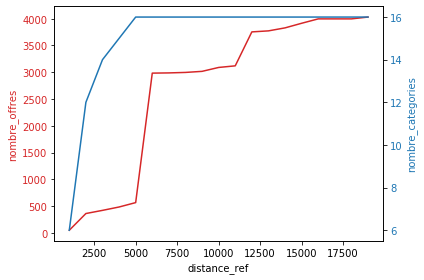

In [158]:
plot_df(paris_df, 'distance_ref', 'nombre_offres', 'nombre_categories')

## Sarcelles (longitude=2.384995, latitude=48.990277)

In [159]:
longitude=2.384995
latitude=48.990277

In [160]:
#sarcelles_df = pd.DataFrame({'distance_ref' : list(distance_ref)})
sarcelles_df = pd.DataFrame({'distance_ref' : list(range(5000, 40000, 1000))})

In [161]:
sarcelles_df['longitude'] = longitude
sarcelles_df['latitude'] = latitude
sarcelles_df['lieu'] = 'sarcelles'

In [162]:
sarcelles_gdf = gpd.GeoDataFrame(sarcelles_df, geometry=gpd.points_from_xy(sarcelles_df.longitude, sarcelles_df.latitude))
sarcelles_gdf.crs = {'init': 'epsg:4326'}

In [163]:
sarcelles_df.head()

,distance_ref,longitude,latitude,lieu,geometry
0,5000,2.384995,48.990277,sarcelles,POINT (2.38499 48.99028)
1,6000,2.384995,48.990277,sarcelles,POINT (2.38499 48.99028)
2,7000,2.384995,48.990277,sarcelles,POINT (2.38499 48.99028)
3,8000,2.384995,48.990277,sarcelles,POINT (2.38499 48.99028)
4,9000,2.384995,48.990277,sarcelles,POINT (2.38499 48.99028)


## Nombres d'offres

In [164]:
sarcelles_df['nombre_offres'] = sarcelles_df.apply(lambda row : get_num_offers(engine, row['longitude'], row['latitude'], row['distance_ref']), axis=1)

## Nombres de catégories

In [165]:
sarcelles_df['nombre_categories'] = sarcelles_df.apply(lambda row : get_num_categories(engine, row['longitude'], row['latitude'], row['distance_ref']), axis=1)

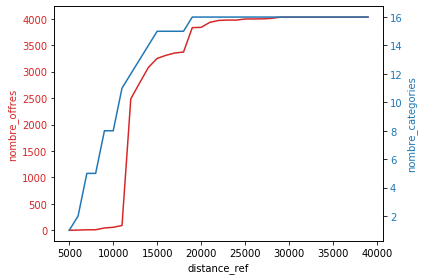

In [166]:
plot_df(sarcelles_df, 'distance_ref', 'nombre_offres', 'nombre_categories')

## Aulnay (longitude=2.5167, latitude=48.95)

In [167]:
longitude=2.5167
latitude=48.95

In [168]:
aulnay_df = pd.DataFrame({'distance_ref' : list(range(1000, 30000, 1000))})

In [169]:
aulnay_df['longitude'] = longitude
aulnay_df['latitude'] = latitude
aulnay_df['lieu'] = 'sarcelles'
aulnay_gdf = gpd.GeoDataFrame(aulnay_df, geometry=gpd.points_from_xy(aulnay_df.longitude, aulnay_df.latitude))
aulnay_gdf.crs = {'init': 'epsg:4326'}

## Nombres d'offres

In [170]:
aulnay_df['nombre_offres'] = aulnay_df.apply(lambda row : get_num_offers(engine, row['longitude'], row['latitude'], row['distance_ref']), axis=1)

## Nombres de catégories

In [171]:
aulnay_df['nombre_categories'] = aulnay_df.apply(lambda row : get_num_categories(engine, row['longitude'], row['latitude'], row['distance_ref']), axis=1)

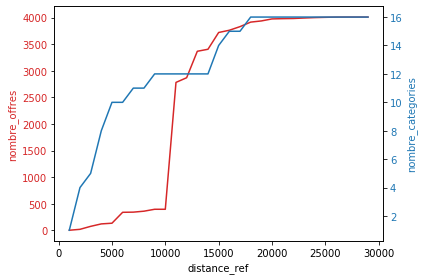

In [172]:
plot_df(aulnay_df, 'distance_ref', 'nombre_offres', 'nombre_categories')

## Bretagne centre

In [173]:
longitude=-2.614613
latitude=48.162784

In [174]:
bretagne_df = pd.DataFrame({'distance_ref' : list(range(5000, 80000, 1000))})
bretagne_df['longitude'] = longitude
bretagne_df['latitude'] = latitude
bretagne_df['lieu'] = 'sarcelles'
bretagne_gdf = gpd.GeoDataFrame(bretagne_df, geometry=gpd.points_from_xy(bretagne_df.longitude, bretagne_df.latitude))
bretagne_gdf.crs = {'init': 'epsg:4326'}
bretagne_df['nombre_offres'] = bretagne_df.apply(lambda row : get_num_offers(engine, row['longitude'], row['latitude'], row['distance_ref']), axis=1)
bretagne_df['nombre_categories'] = bretagne_df.apply(lambda row : get_num_categories(engine, row['longitude'], row['latitude'], row['distance_ref']), axis=1)

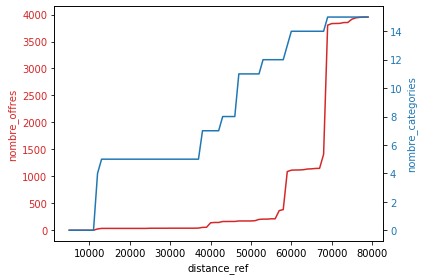

In [175]:
plot_df(bretagne_df, 'distance_ref', 'nombre_offres', 'nombre_categories')

In [176]:
bretagne_df.head(10)

,distance_ref,longitude,latitude,lieu,geometry,nombre_offres,nombre_categories
0,5000,-2.614613,48.162784,sarcelles,POINT (-2.61461 48.16278),0,0
1,6000,-2.614613,48.162784,sarcelles,POINT (-2.61461 48.16278),0,0
2,7000,-2.614613,48.162784,sarcelles,POINT (-2.61461 48.16278),0,0
3,8000,-2.614613,48.162784,sarcelles,POINT (-2.61461 48.16278),0,0
4,9000,-2.614613,48.162784,sarcelles,POINT (-2.61461 48.16278),0,0
5,10000,-2.614613,48.162784,sarcelles,POINT (-2.61461 48.16278),0,0
6,11000,-2.614613,48.162784,sarcelles,POINT (-2.61461 48.16278),0,0
7,12000,-2.614613,48.162784,sarcelles,POINT (-2.61461 48.16278),24,4
8,13000,-2.614613,48.162784,sarcelles,POINT (-2.61461 48.16278),34,5
9,14000,-2.614613,48.162784,sarcelles,POINT (-2.61461 48.16278),34,5


## Quimper

In [177]:
longitude=-4.107512
latitude=47.977196

In [178]:
quimper_df = pd.DataFrame({'distance_ref' : list(range(5000, 100000, 1000))})
quimper_df['longitude'] = longitude
quimper_df['latitude'] = latitude
quimper_df['lieu'] = 'sarcelles'
quimper_df = gpd.GeoDataFrame(quimper_df, geometry=gpd.points_from_xy(quimper_df.longitude, quimper_df.latitude))
quimper_df.crs = {'init': 'epsg:4326'}
quimper_df['nombre_offres'] = quimper_df.apply(lambda row : get_num_offers(engine, row['longitude'], row['latitude'], row['distance_ref']), axis=1)
quimper_df['nombre_categories'] = quimper_df.apply(lambda row : get_num_categories(engine, row['longitude'], row['latitude'], row['distance_ref']), axis=1)

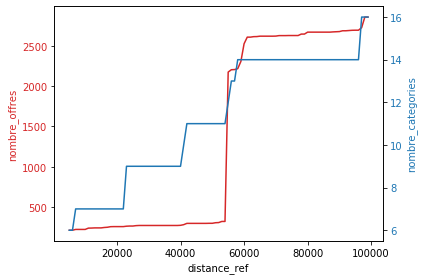

In [179]:
plot_df(quimper_df, 'distance_ref', 'nombre_offres', 'nombre_categories')

## pres_de_charlesville_mezieres

In [180]:
longitude=4.830971
latitude=49.881626

In [181]:
pres_de_charlesville_mezieres = pd.DataFrame({'distance_ref' : list(range(5000, 100000, 1000))})
pres_de_charlesville_mezieres['longitude'] = longitude
pres_de_charlesville_mezieres['latitude'] = latitude
pres_de_charlesville_mezieres['lieu'] = 'sarcelles'
pres_de_charlesville_mezieres = gpd.GeoDataFrame(pres_de_charlesville_mezieres, geometry=gpd.points_from_xy(pres_de_charlesville_mezieres.longitude, pres_de_charlesville_mezieres.latitude))
pres_de_charlesville_mezieres.crs = {'init': 'epsg:4326'}
pres_de_charlesville_mezieres['nombre_offres'] = pres_de_charlesville_mezieres.apply(lambda row : get_num_offers(engine, row['longitude'], row['latitude'], row['distance_ref']), axis=1)
pres_de_charlesville_mezieres['nombre_categories'] = pres_de_charlesville_mezieres.apply(lambda row : get_num_categories(engine, row['longitude'], row['latitude'], row['distance_ref']), axis=1)

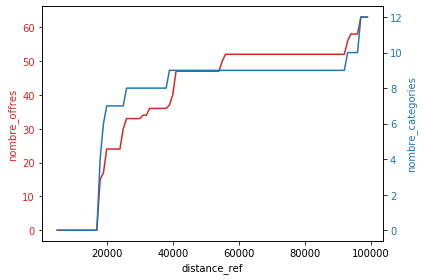

In [182]:
plot_df(pres_de_charlesville_mezieres, 'distance_ref', 'nombre_offres', 'nombre_categories')